This code uses XGBOOST for regression. <br>
The algorithm is retrained to predict every new test point. <br>
The penultimate cell contains the code for algorithm trained on lagged values + concept indicator dummies. <br>
The last cell contains the code for algorithm trained only on lagged values.

In [1]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
import json

function for calculating *Symmetric Mean Absolute Percentage Error*.

In [2]:
def smape(predictions, actual):
    difference = np.abs(predictions-actual)
    summation = np.abs(actual)+np.abs(predictions)
    error = np.mean(difference/summation)
    return error

Because we are in forecasting mode, we cannot shuffle the data for evaluation. Instead we are going to use *walk-forward validation*.<br><br>
In walk-forward validation, the dataset is first split into train and test sets using a cut-point. If we are interested in one time-step forecast, then we can evaluate the model by training on the training sset and predicting first step in the test dataset. Then add the real observation from test set to the training, refit the model, predict the second step and so on...

In [3]:
# walk-forward validation for univariate data
def walk_forward_validation(train, test):
    predictions = []
    history = train.copy()
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        #target y is the first column in the dataset
        test_X, test_y = test.iloc[i, 1:], test.iloc[i, 0]
        
        #test_X is a series, but our model was trained on dataframe
        test_X = test_X.to_frame().T.reset_index(drop = True)
        
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, test_X)
        predictions.append(yhat)
        
        #appending test observation to training requires transforming it to dataframe
        new_data = test.iloc[i].to_frame().T.reset_index(drop = True)
        # add actual observation to training data for the next loop
        history = history.append(new_data, ignore_index = True)
        
    # estimate prediction error
    error = smape(predictions, test.iloc[:, 0], )
    
    return error, test.iloc[:, 0].reset_index(drop = True), predictions

The *xgboost_forecast()* function takes training dataset and test input row as input, fitting the model and making one-step prediction.

In [4]:
def xgboost_forecast(train, test_X):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 40)
    model.fit(train_X, train_y)
    yhat = model.predict(test_X)
    
    return yhat[0]

In [5]:
def preprocessing(data):
    n = len(data)
    
    #transforming concept and transition columns
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    
    #train/test split
    train, test = data[:int(0.7*n)], data[int(0.7*n):]    
    
    return train, test

In [6]:
list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
                "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt",
                "linear1_inc", "linear2_inc", "linear3_inc",
                "nonlinear1_inc", "nonlinear2_inc", "nonlinear3_inc"]

Time wasted: 263.22s
SMAPE: 0.3017


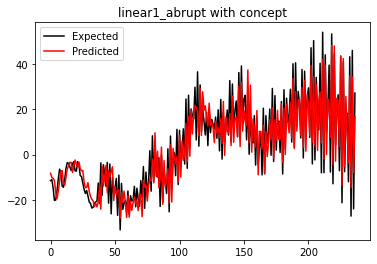

Time wasted: 129.31s
SMAPE: 0.0079


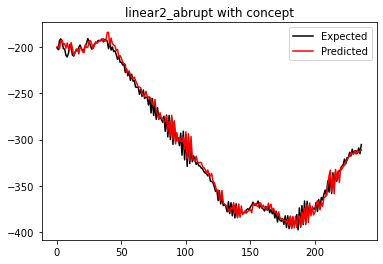

Time wasted: 77.71s
SMAPE: 0.1030


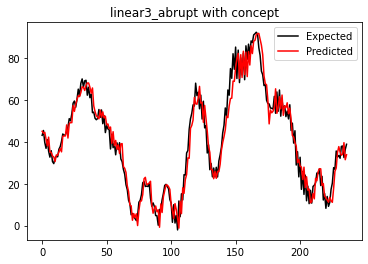

Time wasted: 82.86s
SMAPE: 0.6476


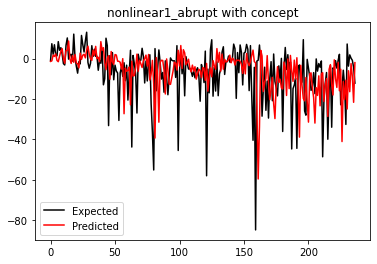

Time wasted: 93.49s
SMAPE: 0.0062


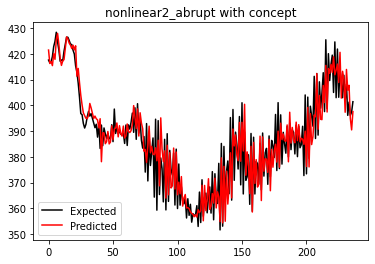

Time wasted: 112.63s
SMAPE: 0.2756


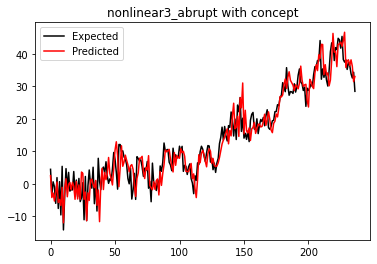

Time wasted: 104.87s
SMAPE: 0.3079


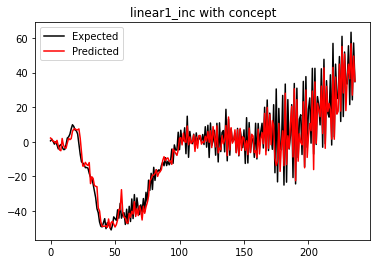

Time wasted: 89.79s
SMAPE: 0.0158


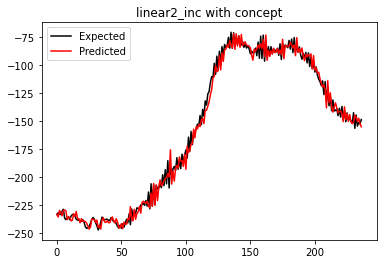

Time wasted: 89.59s
SMAPE: 0.1276


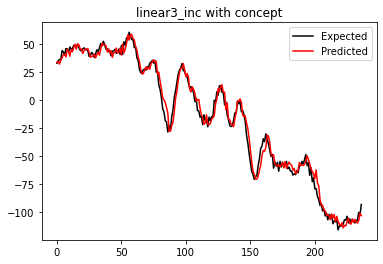

Time wasted: 91.52s
SMAPE: 0.6503


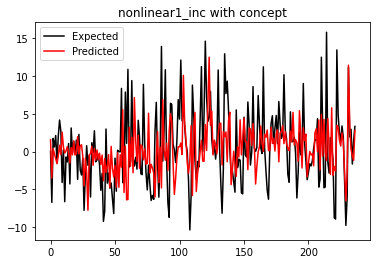

Time wasted: 87.66s
SMAPE: 0.0968


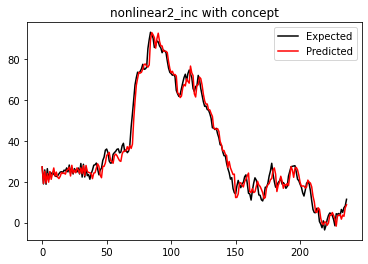

Time wasted: 117.47s
SMAPE: 0.5495


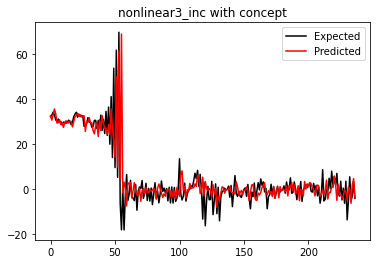

In [7]:
smape_dict_with = {}

for name in list_of_names:
    #loading the data
    file_path = "data/"+name
    data = pd.read_csv(file_path)
    
    #simple preprocessing
    train, test = preprocessing(data)
    
    #fitting and plotting with concept
    start = time.perf_counter()
    error, y, yhat = walk_forward_validation(train, test)
    end = time.perf_counter()
    print("Time wasted: {:.2f}s".format((end-start)))
    
    smape_dict_with[name] = error
    print("SMAPE: {:.4f}".format(error))
    plt.plot(y, label = "Expected", color = "black")
    plt.plot(yhat, label = "Predicted", color = "red")
    plt.legend()
    plt.title("{} with concept".format(name))
    
    #saving the plots
    image_path = "forecasting_results/xgboost/with/"+name+".png"
    plt.savefig(image_path)
    
    plt.show()

#saving the dictionary containing errors
dict_path = "forecasting_results/xgboost/with/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict_with))

Time wasted: 263.58s
SMAPE: 0.2816


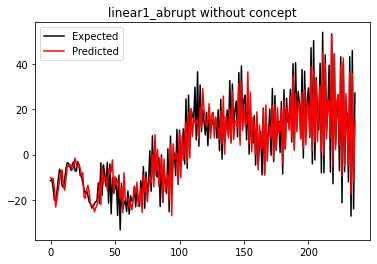

Time wasted: 226.47s
SMAPE: 0.0083


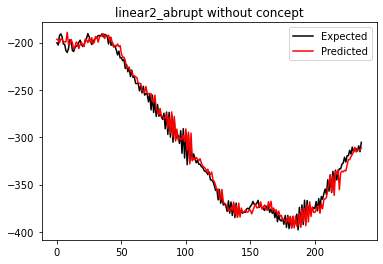

Time wasted: 373.60s
SMAPE: 0.1050


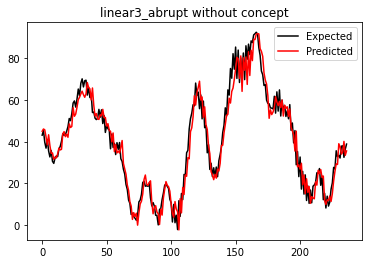

Time wasted: 389.11s
SMAPE: 0.6562


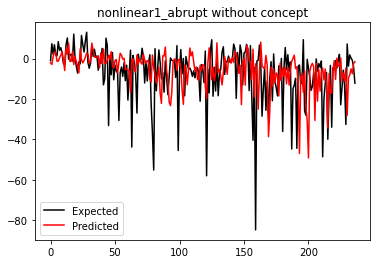

Time wasted: 302.59s
SMAPE: 0.0062


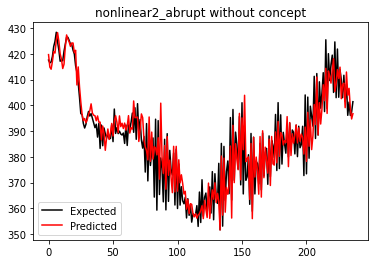

Time wasted: 265.33s
SMAPE: 0.2882


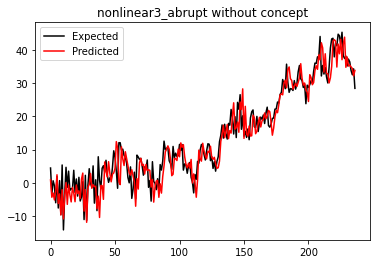

Time wasted: 153.15s
SMAPE: 0.3045


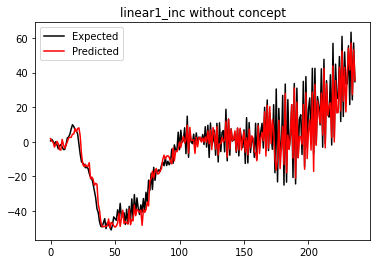

Time wasted: 140.95s
SMAPE: 0.0158


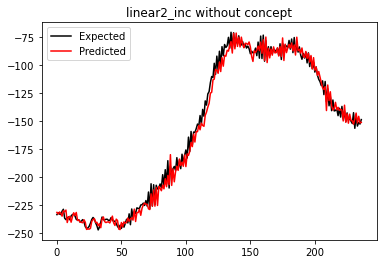

Time wasted: 141.43s
SMAPE: 0.1286


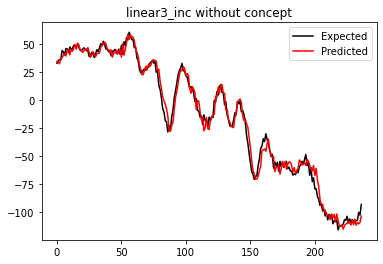

Time wasted: 149.02s
SMAPE: 0.6990


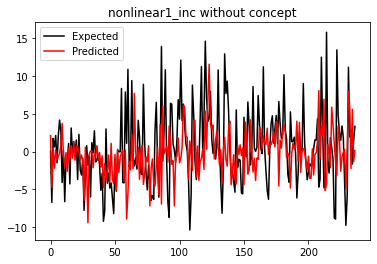

Time wasted: 151.57s
SMAPE: 0.0976


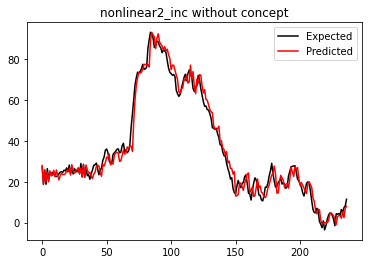

Time wasted: 145.62s
SMAPE: 0.5455


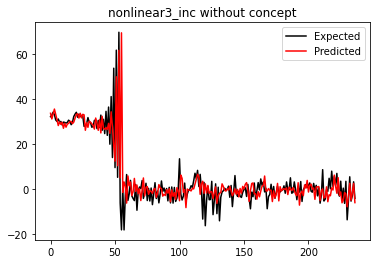

In [8]:
smape_dict_without = {}

for name in list_of_names:
    #loading the data
    file_path = "data/"+name
    data = pd.read_csv(file_path)
    
    #simple preprocessing
    train, test = preprocessing(data)
    
    #fitting and plotting with concept
    start = time.perf_counter()
    error, y, yhat = walk_forward_validation(train.loc[:,"t":"t-5"], test.loc[:,"t":"t-5"])
    end = time.perf_counter()
    print("Time wasted: {:.2f}s".format((end-start)))
    
    smape_dict_without[name] = error
    print("SMAPE: {:.4f}".format(error))
    plt.plot(y, label = "Expected", color = "black")
    plt.plot(yhat, label = "Predicted", color = "red")
    plt.legend()
    plt.title("{} without concept".format(name))
    
    #saving the plots
    image_path = "forecasting_results/xgboost/without/"+name+".png"
    plt.savefig(image_path)
    
    plt.show()
    
#saving the dictionary containing errors
dict_path = "forecasting_results/xgboost/without/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict_without))

In [13]:
#difference in error (without concepts - with concept)
#positive if including concept improved the performance
difference = {x: smape_dict_without[x] - smape_dict_with[x] for x in smape_dict_without if x in smape_dict_with}

In [14]:
difference

{'linear1_abrupt': -0.020024639248880705,
 'linear2_abrupt': 0.0004087210509586721,
 'linear3_abrupt': 0.0020761373967761454,
 'nonlinear1_abrupt': 0.008595022378545703,
 'nonlinear2_abrupt': 3.6157788766050074e-05,
 'nonlinear3_abrupt': 0.012596148823698639,
 'linear1_inc': -0.003386369703667458,
 'linear2_inc': -8.238249508414619e-06,
 'linear3_inc': 0.0010467388013409296,
 'nonlinear1_inc': 0.04875061977226325,
 'nonlinear2_inc': 0.0008457230309880243,
 'nonlinear3_inc': -0.003954389269447023}